# Normalize STFT in a way compatible with librosa

See the librosa code to confirm how librosa. Make sure to pass the same ```ref```.

* [librosa.amplitude_to_db(S, *, ref=1.0, amin=1e-05, top_db=80.0)](https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html#librosa.amplitude_to_db)

> This is equivalent to power_to_db(S**2, ref=ref**2, amin=amin**2, top_db=top_db), but is provided for convenience.

```
power_to_db(power, ref=ref_value**2, amin=amin**2, top_db=top_db)
```

* [librosa.power_to_db(S, *, ref=1.0, amin=1e-10, top_db=80.0)](https://librosa.org/doc/main/_modules/librosa/core/spectrum.html#power_to_db)

> Convert a power spectrogram (amplitude squared) to decibel (dB) units. This computes the scaling ```10 * log10(S / ref)``` in a numerically stable way.

```
    if callable(ref):
        # User supplied a function to calculate reference power
        ref_value = ref(magnitude)
    else:
        ref_value = np.abs(ref)

    log_spec: np.ndarray = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ParameterError("top_db must be non-negative")
        log_spec = np.maximum(log_spec, log_spec.max() - top_db)
```

* [What is the conceptual purpose of librosa.amplitude_to_db?](https://stackoverflow.com/a/63353089)

> Note that the reference (0 dB) point in decibels can be chosen freely. The default for librosa.amplitude_to_db is to compute numpy.max, meaning that the max value of the input will be mapped to 0 dB. All other values will then be negative. The function also applies a threshold on the range of sounds, by default 80 dB. So anything lower than -80 dB will be clipped -80 dB.

STFT dB.max(): -6.069194715477306 dB.mean(): -76.22359215546294


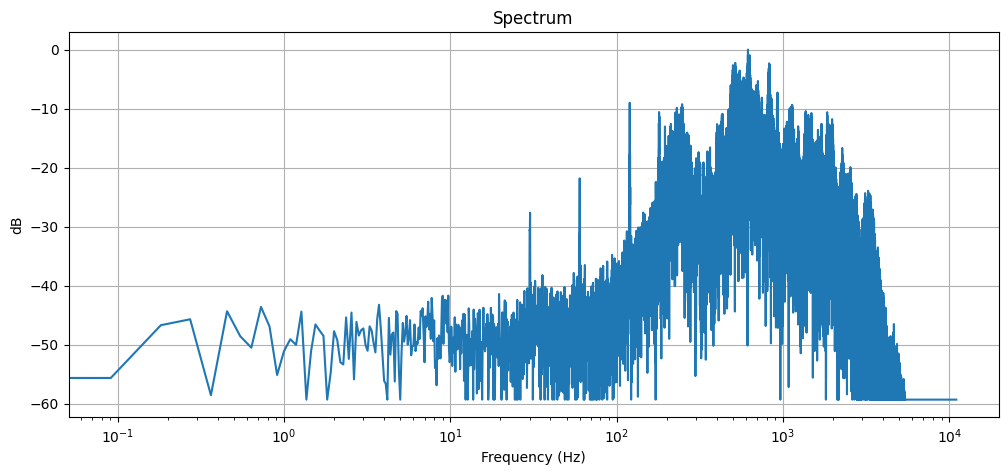

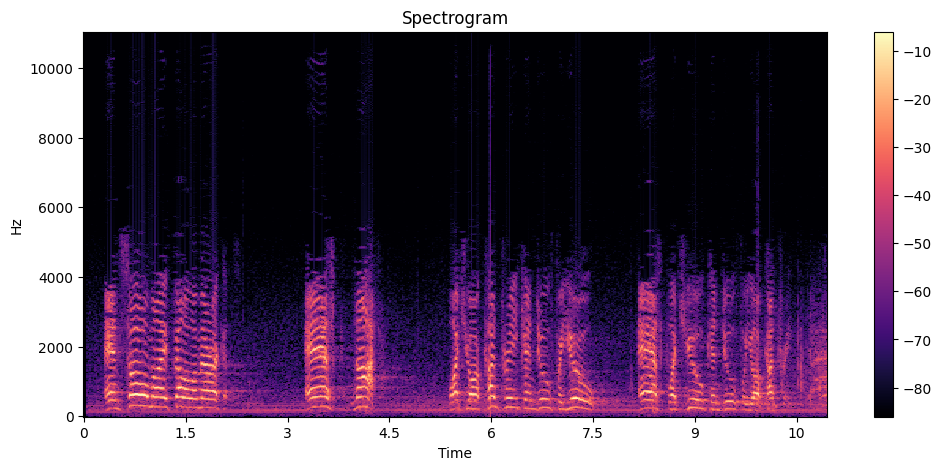

Librosa S_dB.max(): -6.06919527053833 S_dB.mean(): -76.23786926269531


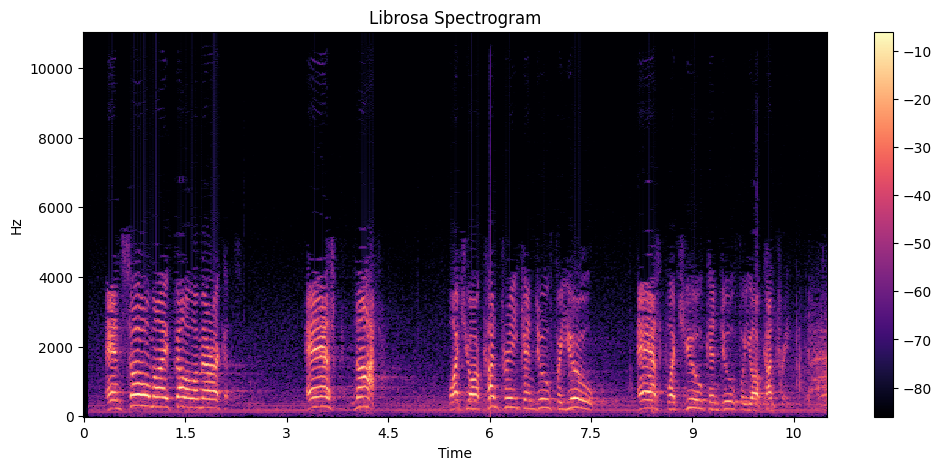

In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np



def sliding_windows_on_1d_array(
        x: np.ndarray, window_size: int, slide_size: int
) -> np.ndarray:
    """Apply a sliding windows on a 1D array to create a (x-rows, d-columns) array.
    Truncate the trailing items that do not fit into the windows.

    Args:
        x: 1D array to apply the sliding windows.
        window_size: size of window to apply
        slide_size: step side to slide the window

    Returns: numpy array of shape (num_rows, window_size) where num_rows = ((x.size - window_size) // slide_size) + 1
    """
    x = x.reshape(-1)
    num_rows = ((x.size - window_size) // slide_size) + 1
    item_size: int = x.strides[0]               # item size of an element in 1D array x.
    return np.lib.stride_tricks.as_strided(
        x,
        shape=(num_rows, window_size),          # result shape
        strides=(
            slide_size * item_size,             # stride[0] in the result shape (row size)
            item_size                           # stride[1] in the result shape (col size)
        )
    )

# --------------------------------------------------------------------------------
# https://github.com/openai/whisper/blob/main/tests/jfk.flac
# wget -P ./data https://github.com/openai/whisper/blob/main/tests/jfk.flac
# --------------------------------------------------------------------------------
data, sampling_rate = librosa.load("./data/jfk.flac")
dft = np.fft.rfft(data, norm="forward")    # "forward normalized by 1/N.
F = np.fft.rfftfreq(n=len(data), d=1/sampling_rate)
A = 2 * np.abs(dft)   # amplitude
A_dB = librosa.amplitude_to_db(A, ref=np.max)

plt.figure(figsize=(12,5))
plt.title("Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("dB")
plt.grid()
plt.xscale("log")
plt.plot(F, A_dB)

# --------------------------------------------------------------------------------
# Specrogram by STFT from scractch
# --------------------------------------------------------------------------------
window_size = 1024    # Number of samples in the shoft-time frame
slide_size = 512      # Size to slide the window for the next frame
window_array = np.hamming(M=window_size)

# Create frames
frames: np.ndarray = sliding_windows_on_1d_array(
    x=data,
    window_size=window_size,
    slide_size=slide_size
)

# Apply hanning window
windows = frames * window_array

# FFT on each window. Transpose because librosa.display.specshow expects an array of frequency per row.
stft = np.fft.rfft(windows, norm="backward").T
magnitude =  np.abs(stft)

# How to normalize magnitude to amplitude? 
# See https://dsp.stackexchange.com/a/49186/73490
amplitude = 2 * magnitude / np.sum(window_array)


# Spectrogram.
# Make sure to pass the same ```ref```.
dB = librosa.amplitude_to_db(amplitude, ref=1.0)
print(f"STFT dB.max(): {dB.max()} dB.mean(): {dB.mean()}")

plt.figure(figsize=(12,5))
plt.title("Spectrogram")
librosa.display.specshow(dB, sr=sampling_rate, hop_length=slide_size,  x_axis="time", y_axis="linear")
plt.colorbar()
plt.show()

# --------------------------------------------------------------------------------
# Librosa
# --------------------------------------------------------------------------------
D = librosa.stft(data, n_fft=window_size, win_length=window_size, hop_length=slide_size, window=np.hamming(window_size))
# Make sure to pass the same ```ref```.
S_dB = librosa.amplitude_to_db(2 * np.abs(D) / np.sum(window_array), ref=1.0)
print(f"Librosa S_dB.max(): {S_dB.max()} S_dB.mean(): {S_dB.mean()}")

plt.figure(figsize=(12,5))
plt.title("Librosa Spectrogram")
librosa.display.specshow(
    S_dB,
    sr=sampling_rate,
    hop_length=slide_size,
    x_axis="time", 
    y_axis="linear"
)
plt.colorbar()